In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/MyDrive/job_test')
print(os.listdir())

['glove.6B.200d.txt', 'train_data.csv']


In [6]:
#Reading Dataset
dataset = pd.read_csv("train_data.csv")
dataset.head()
dataset.shape

(32000, 2)

In [8]:

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [9]:
X = []
sentences = list(dataset['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [10]:
print(X[3])

OMG this is one of the worst films iv ever seen and iv seen lot m Film student don understand why Angelina Jolie would be in this movie Did she need the money that badly love AJ and have seen almost everything shes ever been in so watched this tick another one off It was SOO bad not even good bad just bad bad It had or funny little moments but all in all it was bad a waste of minutes cant even say AJ looked good in it because well she didn The plot is predictable unless you expecting re telling of Romeo and Juliet then its not All round disappointing Maybe if your this could be good film otherwise really don recommend it 


In [11]:

Y = dataset['sentiment']

#Converting Labels into integers
Y = np.array(list(map(lambda x: 1 if x=="positive" else 0, Y)))

In [12]:
#spliting the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [13]:
#extract tokens from the text the number of tokens is 5000
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

In [14]:
#Tokenization
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
#Finding Unique Tokens
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % vocab_size)

Found 76942 unique tokens.


In [16]:
#padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 256
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [17]:
#Word embeddings using Glove
from numpy import asarray
embeddings_dictionary = dict()
glove_file = open('./glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split(' ')
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [18]:
from numpy import zeros
embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [19]:
#Building LSTM model
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Embedding
from keras.layers import Flatten, LSTM

model = Sequential()
embedding_layer = Embedding(vocab_size, 200,
                            weights=[embedding_matrix],
                            input_length=maxlen ,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(128,return_sequences=True,dropout=0.5))
model.add(LSTM(32,dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics=['acc'])


In [20]:
#Model Summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          15388400  
                                                                 
 lstm (LSTM)                 (None, 256, 128)          168448    
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 15,577,489
Trainable params: 189,089
Non-trainable params: 15,388,400
_________________________________________________________________
None


In [21]:
#defining checkpoints to save best model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

class PrintLossAndAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Training - loss: {logs['loss']:.4f} - accuracy: {logs['acc']:.4f}")
        print(f"Validation - loss: {logs['val_loss']:.4f} - accuracy: {logs['val_acc']:.4f}")
        print()

model_checkpoint_path = "/content/drive/MyDrive/job_test/best_model.h5"
checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

In [22]:
#Training of LSTM
epochs = 25
training = model.fit(X_train, Y_train, batch_size=128, epochs = epochs, verbose=1, shuffle=False,validation_data=(X_test,Y_test),callbacks=[checkpoint, PrintLossAndAccuracy()])


Epoch 1/25
200/200 [==============================] - ETA: 0s - loss: 0.2418 - acc: 0.5557
Epoch 1: val_acc improved from -inf to 0.70000, saving model to /content/drive/MyDrive/job_test/best_model.h5
Epoch 1/25
Training - loss: 0.2418 - accuracy: 0.5557
Validation - loss: 0.2056 - accuracy: 0.7000

200/200 [==============================] - 311s 2s/step - loss: 0.2418 - acc: 0.5557 - val_loss: 0.2056 - val_acc: 0.7000
Epoch 2/25
200/200 [==============================] - ETA: 0s - loss: 0.2226 - acc: 0.6532
Epoch 2: val_acc improved from 0.70000 to 0.74937, saving model to /content/drive/MyDrive/job_test/best_model.h5
Epoch 2/25
Training - loss: 0.2226 - accuracy: 0.6532
Validation - loss: 0.1870 - accuracy: 0.7494

200/200 [==============================] - 311s 2s/step - loss: 0.2226 - acc: 0.6532 - val_loss: 0.1870 - val_acc: 0.7494
Epoch 3/25
200/200 [==============================] - ETA: 0s - loss: 0.2318 - acc: 0.6311
Epoch 3: val_acc did not improve from 0.74937
Epoch 3/25
Tra

In [23]:
#Model Evaluation with test data
score = model.evaluate(X_test, Y_test, verbose=1)

200/200 [==============================] - 42s 207ms/step - loss: 0.0779 - acc: 0.8977


In [24]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix,classification_report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm =confusion_matrix(y_pred, Y_test)
cm
print(classification_report(y_pred,Y_test))

200/200 [==============================] - 42s 203ms/step
              precision    recall  f1-score   support

       False       0.86      0.93      0.89      2956
        True       0.93      0.87      0.90      3444

    accuracy                           0.90      6400
   macro avg       0.90      0.90      0.90      6400
weighted avg       0.90      0.90      0.90      6400



In [26]:
#Ploting model history in terms of Accuracy and loss

def plot_learningCurve(trained_model, epochs):
   epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, trained_model.history['acc'])
  plt.plot(epoch_range, trained_model.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  plt.plot(epoch_range, trained_model.history['loss'])
  plt.plot(epoch_range, trained_model.history['val_loss'])

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

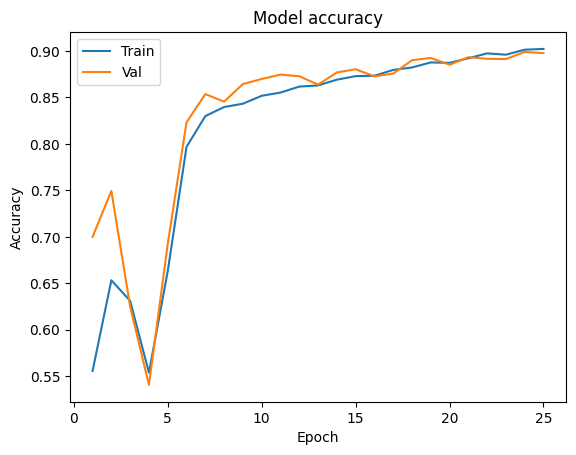

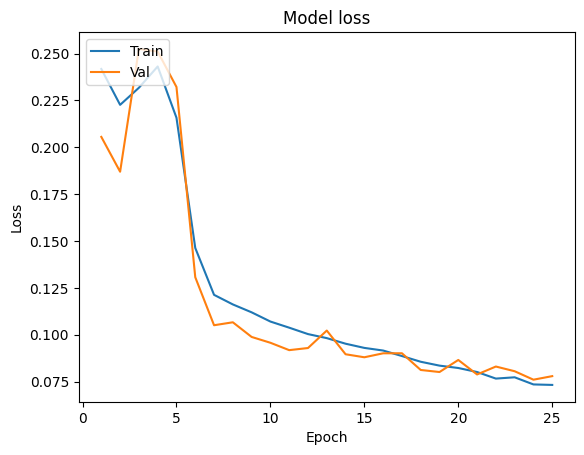

In [27]:
plot_learningCurve(training, 25)